# Academic test

In [132]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

### Parameters to be used 

In [133]:
T = 1
gamma = 1
alpha_g = 2
beta_g = 1.27 * 10**(-3)
sigma_g = 0.1863
r = 0.02

In [134]:
g_bar = 0.5
g_hat = 2*g_bar
b_hat = 1

## First Numerical Method 

### Parameters to be used 

In [135]:
omega = 2
eps = 10**(-5)

In [136]:
space_steps = 32
time_steps = 40

In [137]:
delta_tau = gamma/time_steps
tau_mesh = [n*delta_tau for n in range(time_steps+1)]

Remember: $\hat{B} \in [0,1]$ and $\hat{G} \in [0,1]$.

In [138]:
delta_B = 1/space_steps
B_mesh = [i*delta_B for i in range(space_steps+1)]

delta_G = 1/space_steps
G_mesh = [j*delta_G for j in range(space_steps+1)]

We must solve the linear system: $C(\hat{G})P_i^{n+1} = b_i^n$ at each time step and for each value of $i=1,2,\dots,N_{\hat{B}}-1$.

## Analytical Solution

In [139]:
def analytical_solution(B, G_tilde, T = 1, t = 0):
    return np.exp((T-t)*B*G_tilde)

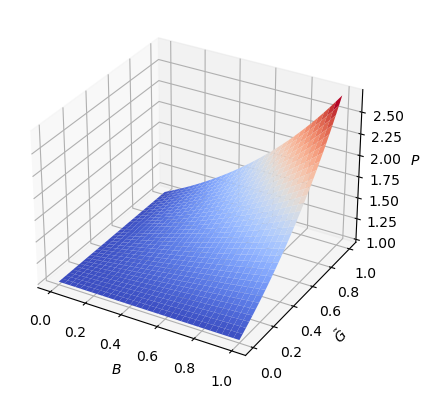

In [140]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Create the mesh in polar coordinates and compute corresponding Z.
B, G_tilde = np.meshgrid(B_mesh, G_mesh)

Z = analytical_solution(B, G_tilde)

# Plot the surface.
ax.plot_surface(B, G_tilde, Z, cmap=cm.coolwarm)

# Tweak the limits and add latex math labels.
ax.set_xlabel(r'$B$')
ax.set_ylabel(r'$\tilde{G}$')
ax.set_zlabel(r'$P$')

plt.show()

### $C(\hat{G}) $ matrix 

In this academic test there is no seasonality, that is, $f=0$.

In [141]:
def f():
    return 0

In [142]:
def c1():
    c1_value = 1 + 0.5*r*delta_tau + 0.5* (g_hat**2 * sigma_g**2 * delta_tau)/(delta_G**2)
    return c1_value

def c2(j):
    c2_value = -0.5*(g_hat**2 * sigma_g**2 * delta_tau)/(2 * delta_G**2) - 0.5 * g_hat * alpha_g *\
    delta_tau * (f() - G_mesh[j]*g_hat-g_bar + beta_g*omega/(2*alpha_g))/(2*delta_G)
    return c2_value

def c3(j):
    c3_value = -0.5*(g_hat**2 * sigma_g**2 * delta_tau)/(2 * delta_G**2) + 0.5 * g_hat * alpha_g *\
    delta_tau * (f() - G_mesh[j]*g_hat-g_bar + beta_g*omega/(2*alpha_g))/(2*delta_G)
    return c3_value

In [143]:
def h(n,i,j):
    tau = [tau_mesh[n] for n in range(len(tau_mesh))]
    G_tilde = [G_mesh[i] * g_hat - g_bar for i in range(len(G_mesh))]
    B = [B_mesh[i] * b_hat for i in range(len(G_mesh))]
    #G_tilde = [G_mesh[i] for i in range(len(G_mesh))]
    #B = [B_mesh[i] for i in range(len(G_mesh))]
    
    
    h_value = np.exp( tau[n] * B[i] * G_tilde[j] ) * \
    (-B[i]*G_tilde[j] + 1/2 * sigma_g**2 * (T-tau[n])**2 * B[i]**2 - \
    (T-tau[n])*B[i]*alpha_g* (f() + (beta_g/alpha_g) * np.exp( tau[n]*B[i]*\
    G_tilde[j])-G_tilde[j] ) - np.exp(G_tilde[j]) * (T-tau[n]) * G_tilde[j] -r)
    return h_value

In [144]:
C_matrix = [[0 for i in range(space_steps+1)] for j in range(space_steps+1)]

In [145]:
#main diagonal
for i in range(1,space_steps):
    C_matrix[i][i] = c1()
    
#top diagonal
for i in range(1,space_steps-1):
    C_matrix[i][i+1] = c2(i)
    
#bottom diagonal
for i in range(1,space_steps-1):
    C_matrix[i+1][i] = c3(i)
    
C_matrix[0][0] = 1
C_matrix[space_steps][space_steps] = 1

### $\left( b_i^n \right)_j$ vector 

This is a vector to be updated in each time step. First you solve the linear system and get to a array $P$ and then subtitute it on the right-hand side of the equation to get the $b$ vector.

In [146]:
def mult_factor1():
    m1_value = (1 - r*delta_tau*0.5) - (sigma_g**2 * g_hat**2 * delta_tau * 0.5)/(delta_G**2)
    return m1_value

def mult_factor3():
    m3_value = (sigma_g**2 * g_hat**2 * delta_tau * 0.5)/(2 * delta_G**2)
    return m3_value

def mult_factor5():
    m5_value = 0.5 * g_hat * delta_tau * beta_g / (4*delta_G)
    return m5_value


In [147]:
def m(theta, P, omega=2):
    if P + theta/(2*omega) <=0:
        a = -theta - 2*omega*P
        return a
    else:
        b = theta + 2*omega*P + omega**2 - omega * np.sqrt(4*theta + 8*omega*P + omega**2)
        return b

## Solving the linear system and updating values 

In [148]:
#Initializing the variables
P = [[1 for i in range(space_steps+1)] for j in range(time_steps+100)]
theta = [[1 for i in range(space_steps+1)] for j in range(time_steps+100)]

I am fixing the last i.

In [233]:
#remember to update boundary conditions
for n in range(time_steps+1):
    theta_n1 = theta.copy()
    P_n = P.copy()
    b = [0 for j in range(space_steps+1)]

    #parameters to start the cycle
    criterion = 1
    k=0
    
    while np.abs(criterion) > eps and k<90:
        
        #constructing the b vector
        for j in range(1,space_steps):
            b[j] = mult_factor1()*P_n[k][j] +\
            ((alpha_g*g_hat*delta_tau*0.5 * (f()-G_mesh[j]*g_hat-g_bar + beta_g/alpha_g*P_n[k][j]))/(2*delta_G))*P_n[k][j+1] +\
            mult_factor3()*(P_n[k][j+1] + P_n[k][j-1])-\
            ((alpha_g*g_hat*delta_tau*0.5 * (f()-G_mesh[j]*g_hat-g_bar + beta_g/alpha_g*P_n[k][j]))/(2*delta_G))*P_n[k][j-1] +\
            mult_factor5()*(theta_n1[k][j+1]-theta_n1[k][j-1]) + \
            mult_factor5()*(theta_n1[0][j+1]-theta_n1[0][j-1]) +\
            h(n,space_steps,j) #i=1 fixed
        b[0] = 1
        b[space_steps] = np.exp(tau_mesh[n] * B_mesh[space_steps] * G_mesh[space_steps]) #i=1 fixed
        #########
        
        #solving the linear system
        newP = np.linalg.solve(C_matrix, b)
        P_n[k] = newP
        ######
        
        #update theta
        theta_updated = [m(theta_n1[k][j], newP[j]) for j in range(space_steps+1)] #check this
        theta_n1[k+1] = theta_updated
        ######
        
        #stopping test
        theta_updated_array = np.array(theta_updated)
        theta_k_array = np.array(theta_n1[k])
        numerator = np.max(theta_updated_array - theta_k_array)
        denominator = np.max(theta_updated_array)
        criterion = numerator/denominator
        #####
        k+=1
    print((k,criterion))
        
    theta[n] = theta_updated
    P[n] = newP


(14, -0.0)
(14, -0.0)
(14, -1.185991820210508e-15)
(14, -0.0)
(14, -0.0)
(14, -1.1590881286995348e-15)
(14, -0.0)
(14, -1.1817918080950016e-15)
(14, -5.971648314434193e-15)
(14, -3.3782883371124605e-14)
(49, -6.467332162658924e-07)
(49, -6.847653580297417e-07)
(49, -4.796979719530188e-07)
(49, -3.0418373049812503e-07)
(45, -2.4101460468021516e-06)
(45, -1.4799927860046806e-06)
(45, -8.389315819216193e-07)
(45, -4.2362945670389113e-07)
(45, -1.7917862710077793e-07)
(45, -1.589865007160789e-07)
(45, -1.8292885706244284e-07)
(45, -2.1343825019785243e-07)
(45, -2.539546087408155e-07)
(45, -3.1083421519664233e-07)
(45, -3.9726287920939365e-07)
(45, -5.457825201688311e-07)
(45, -8.643659839686727e-07)
(45, -2.055992206607645e-06)
(45, 5.4346558617766645e-06)
(45, 1.1645652978339612e-06)
(45, 6.485101376534297e-07)
(45, 4.467901013709578e-07)
(45, 3.388078940773738e-07)
(45, 2.7127319704839276e-07)
(45, 2.24871278201756e-07)
(45, 1.9090904717040547e-07)
(45, 1.6489630697808636e-07)
(45, 1.442

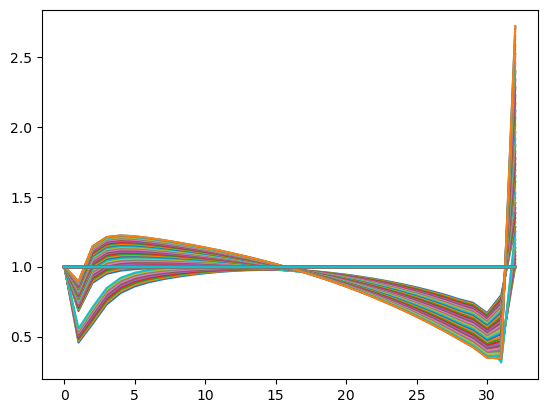

In [234]:
for i in range(len(P)):
    plt.plot(P[i])

In [235]:
tau_mesh[time_steps]

1.0

In [236]:
analytical_solution(B_mesh[space_steps], G_mesh[space_steps],1, 0)

2.718281828459045

In [237]:
P[time_steps][-1]

2.718281828459045

In [238]:
analytical_solution(B_mesh[space_steps], G_mesh[space_steps],1, 1)

1.0

In [240]:
P[0][-1]

1.0

comparing the solution with j=32, i=1

Text(0.5, 1.0, 'Comparação com $B$ fixo, $t=0$')

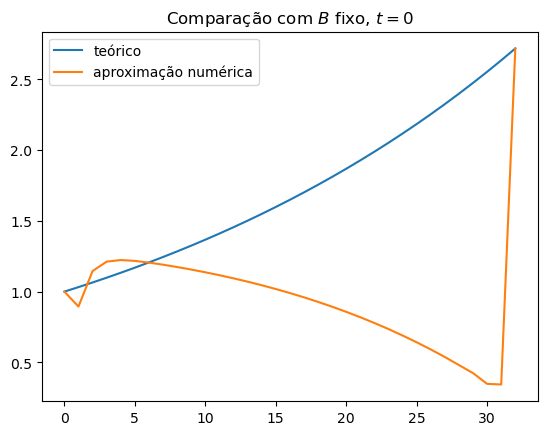

In [213]:
sol = []
for i in range(space_steps+1):
    sol.append(np.exp(tau_mesh[40]*B_mesh[space_steps]*G_mesh[i]))
plt.plot(sol,label="teórico")
plt.plot(P[40],label="aproximação numérica")
plt.legend()
plt.title("Comparação com $B$ fixo, $t=0$")

In [80]:
h(0,0,0)

-0.02